# Training and Inference

In [1]:
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import math
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings("ignore")

2025-08-29 13:55:36.967575: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-29 13:55:36.990294: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-29 13:55:37.333806: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Import data

In [2]:
TRAIN_EPOCHS = 100 
NUM_FEATURES = 1 # univariate time series, SINR or PHR or dlBler
TIME_STEP = 100  # Number of past time steps to use
BATCH_SIZE = 1 # it works for time series

INPUT_WIDTH = 64
LABEL_WIDTH = 64
PREDICTION_STEPS = 64 # prediction steps into the future

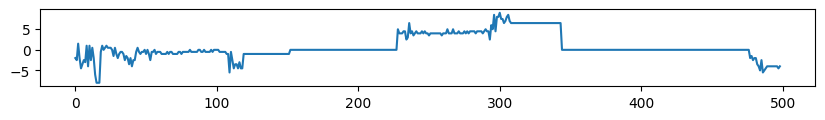

In [3]:
df_raw = pd.read_csv('data_one_feat_sinr_clean.csv', header=None)
plt.figure(figsize=(10, 1))
plot_features = df_raw[0][1:500]
plt.plot(range(len(plot_features)), plot_features)
plt.show()

In [4]:
df = df_raw.copy()
df = df[1:] # full 
df

,0
1,-2.0
2,-2.5
3,1.5
4,-2.0
5,-4.5
...,...
1713,0.0
1714,0.0
1715,0.0
1716,0.0


In [5]:
print(df.shape)
print(df.head())   
print(type(df))

(1717, 1)
     0
1 -2.0
2 -2.5
3  1.5
4 -2.0
5 -4.5
<class 'pandas.core.frame.DataFrame'>


In [6]:
# Scale the data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

# Define the function to create the dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Split the data into training and testing sets
training_size = int(len(scaled_data) * 0.80)
test_size = len(scaled_data) - training_size
train_data, test_data = scaled_data[0:training_size, :], scaled_data[training_size:len(scaled_data), :]

# Create the datasets for training and testing
X_train, y_train = create_dataset(train_data, TIME_STEP)
X_test, y_test = create_dataset(test_data, TIME_STEP)

print(X_train.shape, y_train.shape)

# Reshape the input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape, y_train.shape)

(1272, 100) (1272,)
(1272, 100, 1) (1272,)


In [7]:
print(type(scaled_data))
print(scaled_data.shape)
print(type(df.values))
print(df.values.shape)

<class 'numpy.ndarray'>
(1717, 1)
<class 'numpy.ndarray'>
(1717, 1)


In [9]:
# Build the LSTM model
model = Sequential(name='LSTM_model')
model.add(LSTM(100, return_sequences=True, input_shape=(TIME_STEP, NUM_FEATURES)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', 
              loss='mean_squared_error')

model.summary()

Model: "LSTM_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 100, 100)       │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,301 (282.43 KB)

 Trainable params: 72,301 (282.43 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0126
Epoch 2/100
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0028
Epoch 3/100
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0024
Epoch 4/100
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0017
Epoch 5/100
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0023
Epoch 6/100
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0017
Epoch 7/100
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0017
Epoch 8/100
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0015
Epoch 9/100
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0016
Epoch 10/100
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0012
Epoch 11/100
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0015
Epoch 12/100
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0015
Epoch 13/100
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0012
Epoch 14/100
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0012
E

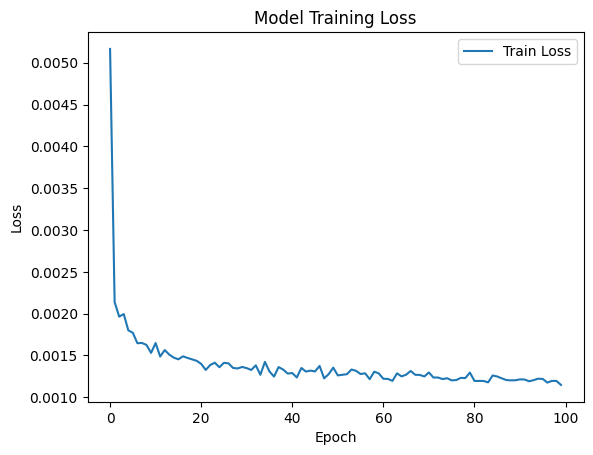

In [ ]:
# Train the model and save the history
history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=TRAIN_EPOCHS)

# Plot the training loss
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
import pandas as pd

# Convert history.history (dict) to DataFrame
history_df = pd.DataFrame(history.history)

# Save to CSV
history_df.to_csv("training_history.csv", index=False)

In [ ]:
# Reload history
loaded_history = pd.read_csv("training_history.csv")

In [ ]:
model.save("lstm_no_window.keras")

# Inference

In [14]:
model = tf.keras.models.load_model('./lstm_no_window.keras')

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Train RMSE: 1.1392813982783045
Test RMSE: 1.712201481494107


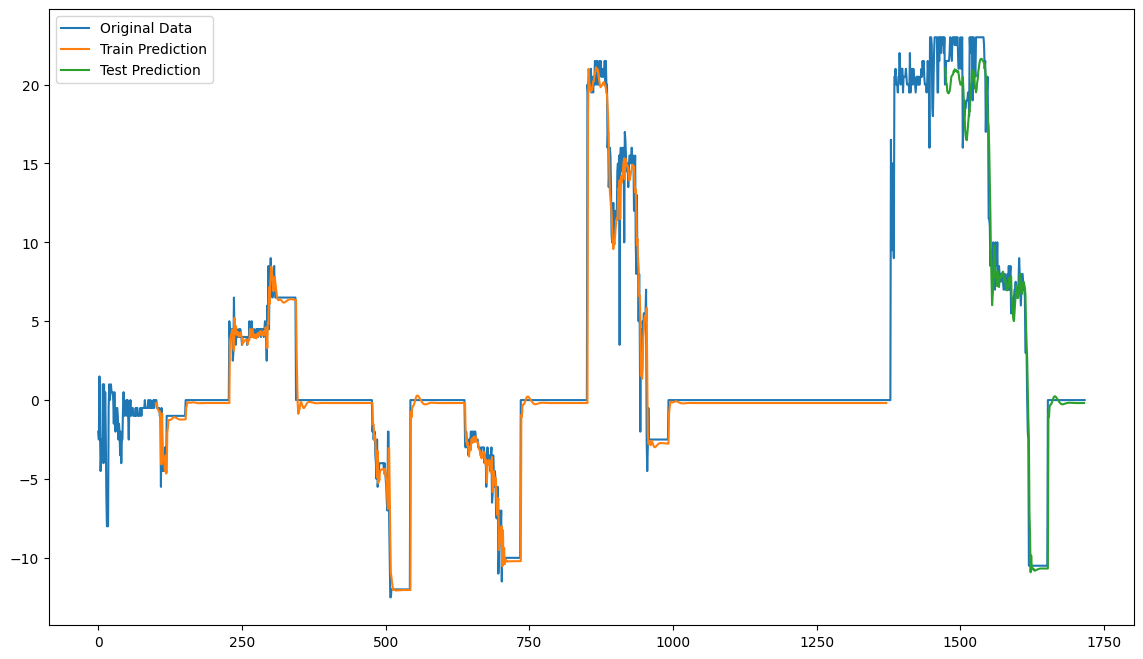

In [ ]:
from sklearn.metrics import mean_squared_error
import math

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transform back to original form (if your data was scaled)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
train_rmse = math.sqrt(mean_squared_error(y_train_inv, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test_inv, test_predict))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

# Plot the results
# Shift train predictions for plotting
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[TIME_STEP:len(train_predict) + TIME_STEP, :] = train_predict

# Shift test predictions for plotting
test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (TIME_STEP * 2) + 1:len(scaled_data) - 1, :] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(14, 8))
plt.plot(scaler.inverse_transform(scaled_data), label='Original Data')
plt.plot(train_predict_plot, label='Train Prediction')
plt.plot(test_predict_plot, label='Test Prediction')
plt.legend()
plt.show()